### Explore GlobalNEWS Alkalinity river input data, total up Alk inputs, modify files for OAE 

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np
import matplotlib.path as mpath
import cmocean
import cftime
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

In [2]:
ds_globalnews = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/pop/gx1v7/forcing/riv_nut.gnews_gnm.gx1v7_nn_open_ocean_nnsm_e1000r300_marginal_sea.20170425.nc')

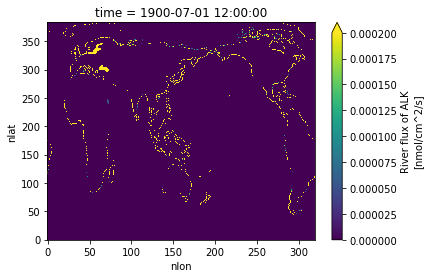

In [3]:
ds_globalnews.alk_riv_flux.isel(time=0).plot(vmin=0,vmax=0.0002)

In [4]:
df_sites = pd.read_csv('OAE_Site_Map_Redacted_Final.csv')
df_sites.loc[0]#['Latitude (N)']

Site Name        Salish Sea/Puget Sound
Latitude (N)                      48.25
Longitude (E)                    -123.4
Name: 0, dtype: object

In [5]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)
area_km2 = area * 1e-10

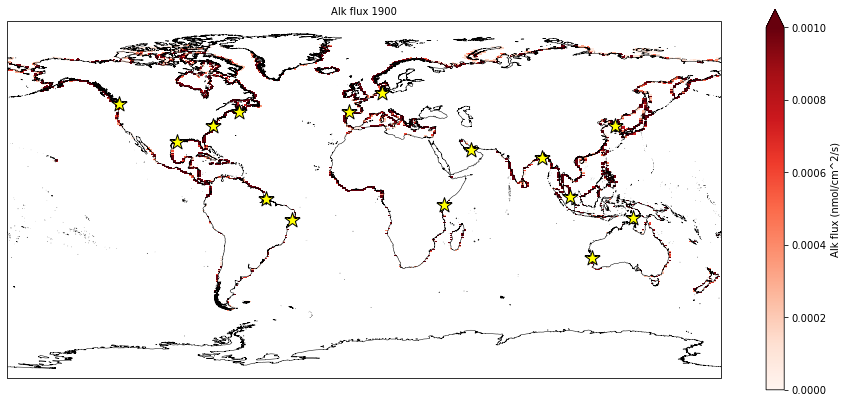

In [6]:
fig = plt.figure(figsize=(16,7))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0)
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.001, 
                  cmap='Reds',
                 transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=250,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())



cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol/cm^2/s)')


### Total up natural global alk flux

In [7]:
alk_tmp = ds_globalnews.alk_riv_flux * area # unit = nmol Alk per second per gridcell

In [8]:
alk_tmp2 = alk_tmp * 86400. * 365 * 1e-9 # unit = mol Alk per year per gridcell

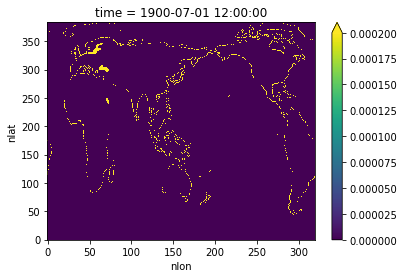

In [9]:
alk_tmp2.isel(time=0).plot(vmin=0,vmax=0.0002)

In [10]:
alk_glb_tot = alk_tmp2.sum(dim=('nlat','nlon'))

In [11]:
alk_glb_totC = alk_glb_tot * 1e-15 * 12.011 # unit = Pg carbon alk equivalents per year
alk_glb_totC

<xarray.DataArray (time: 21)>
array([0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881, 0.26480881, 0.26480881, 0.26480881, 0.26480881,
       0.26480881])
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00

In [12]:
alk_glb_Tmol = alk_glb_tot * 1e-12
alk_glb_Tmol

<xarray.DataArray (time: 21)>
array([22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128, 22.04719128, 22.04719128, 22.04719128, 22.04719128,
       22.04719128])
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00

### 0.022 Pmol (22 Tmol) natural Alkalinity flux from rivers per year

In [13]:
nat_alk_flux = ds_globalnews.alk_riv_flux.isel(time=0) #.where(ds_grid.REGION_MASK>0)
nat_alk_flux = nat_alk_flux.where(nat_alk_flux > 0) * area * 86400. * 365  * 1e-9 # unit = nmol Alk per year per gridcell
nat_alk_glb_tot = nat_alk_flux.sum(dim=('nlat','nlon')) * 1.e-12
nat_alk_glb_tot

<xarray.DataArray ()>
array(22.04719128)
Coordinates:
    time     object 1900-07-01 12:00:00

### Potential "maximum feasible" = add 27 Tmol of Alk total to rivers

In [14]:
### empty ones mask to use for making masks for each region

ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

### 15 regions for OAE 

##### 5Gt CO2/yr is reasonable (even ambitious) for any one CDR pathway and 2 Gt CO2/yr seems like it's probably a pragmatic amount

In [15]:
######## Choose 4 North American regions

### REGION 1: Salish Sea/Puget Sound
box1_latmin = 47
box1_latmax = 49
box1_lonmin = -126.
box1_lonmax = -122.

### REGION 2: Gulf of Mexico, near Houston
box2_latmin = 28
box2_latmax = 30
box2_lonmin = -96.
box2_lonmax = -93.

### REGION 3: Norfolk VA
box3_latmin = 36
box3_latmax = 38
box3_lonmin = -78.
box3_lonmax = -75.

### REGION 4: Halifax Habour
box4_latmin = 43
box4_latmax = 46
box4_lonmin = -65.
box4_lonmax = -61.

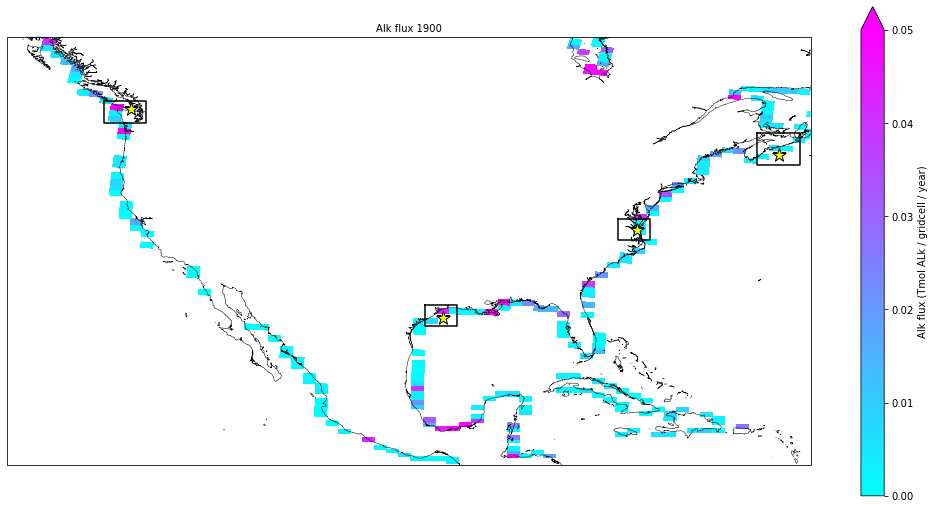

In [16]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-135, -60, 15, 55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


In [17]:
### Choose a South american region

### REGION 5: At the Amazon
box5_latmin = -3
box5_latmax = 2
box5_lonmin = -51.
box5_lonmax = -47.

### REGION 6: Sao Francisco River
box6_latmin = -12
box6_latmax = -9
box6_lonmin = -38.
box6_lonmax = -34.

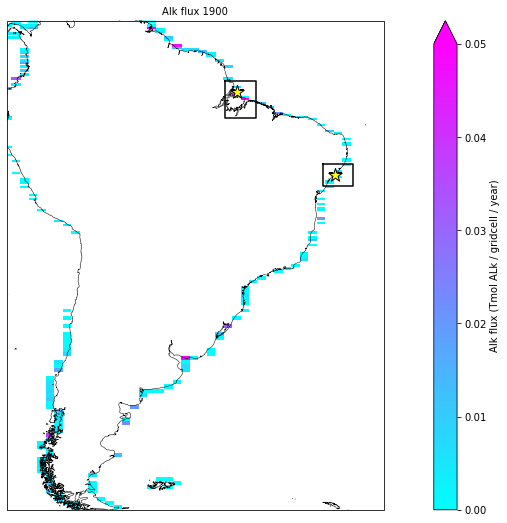

In [18]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-80, -30, -55, 10], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


In [19]:
### Choose a European region

### REGION 7: Ortigueira estuary
box7_latmin = 43
box7_latmax = 45
box7_lonmin = -9
box7_lonmax = -7.

### REGION 8: Elbe Delta
box8_latmin = 53
box8_latmax = 55
box8_lonmin = 8
box8_lonmax = 10

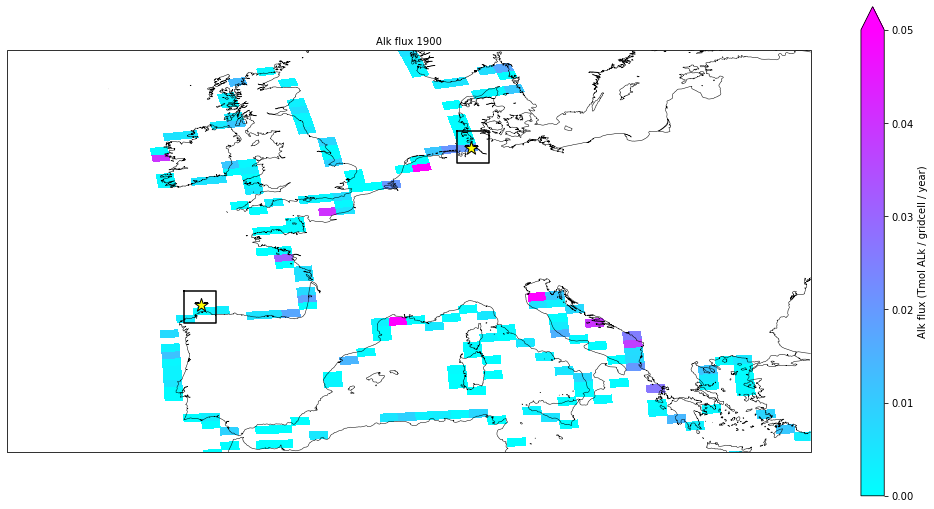

In [20]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 35, 60], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box8_lonmin,box8_lonmax,box8_lonmax,box8_lonmin,box8_lonmin]
lat_pts = [box8_latmax,box8_latmax,box8_latmin,box8_latmin,box8_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### East Africa and Persian Gulf

In [21]:
### REGION 9: Tana River Delta Kenya
box9_latmin = -4.5
box9_latmax = -1
box9_lonmin = 39.
box9_lonmax = 43.

### REGION 10: Persian Gulf
box10_latmin = 24
box10_latmax = 30
box10_lonmin = 48.
box10_lonmax = 56.

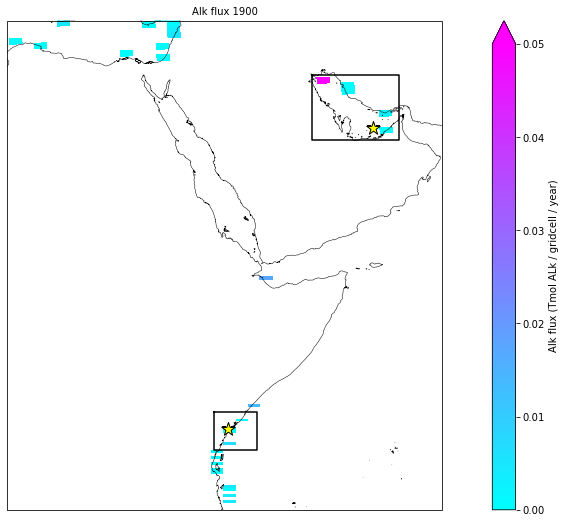

In [22]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([20, 60, -10, 35], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box9_lonmin,box9_lonmax,box9_lonmax,box9_lonmin,box9_lonmin]
lat_pts = [box9_latmax,box9_latmax,box9_latmin,box9_latmin,box9_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box10_lonmin,box10_lonmax,box10_lonmax,box10_lonmin,box10_lonmin]
lat_pts = [box10_latmax,box10_latmax,box10_latmin,box10_latmin,box10_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Asian regions: bay of bengal, singpore, yellow sea

In [23]:
### Let's put one in the Sea of Okhotsk

### REGION 11: Bay of Bengal
box11_latmin = 19
box11_latmax = 23
box11_lonmin = 88.
box11_lonmax = 92.

### REGION 12: Singapore
box12_latmin = 0
box12_latmax = 3
box12_lonmin = 101
box12_lonmax = 106

### REGION 13: Yellow Sea
box13_latmin = 35
box13_latmax = 40
box13_lonmin = 124
box13_lonmax = 128

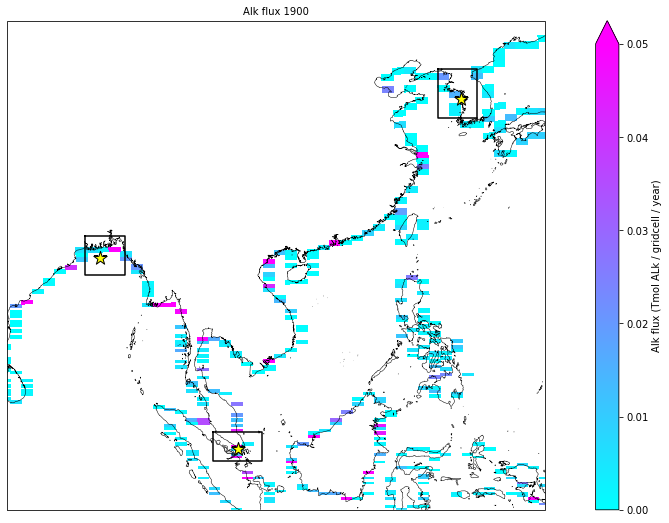

In [24]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([80, 135, -5, 45], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box11_lonmin,box11_lonmax,box11_lonmax,box11_lonmin,box11_lonmin]
lat_pts = [box11_latmax,box11_latmax,box11_latmin,box11_latmin,box11_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box12_lonmin,box12_lonmax,box12_lonmax,box12_lonmin,box12_lonmin]
lat_pts = [box12_latmax,box12_latmax,box12_latmin,box12_latmin,box12_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box13_lonmin,box13_lonmax,box13_lonmax,box13_lonmin,box13_lonmin]
lat_pts = [box13_latmax,box13_latmax,box13_latmin,box13_latmin,box13_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### West side of Australia Indian Ocean and Timor-Arafura Sea

In [25]:
### REGION 14: West coast Australia, Indian Ocean
box14_latmin = -33
box14_latmax = -28
box14_lonmin = 112.
box14_lonmax = 117.

### REGION 15: Timor-Arafura Sea
box15_latmin = -14
box15_latmax = -9
box15_lonmin = 133
box15_lonmax = 138

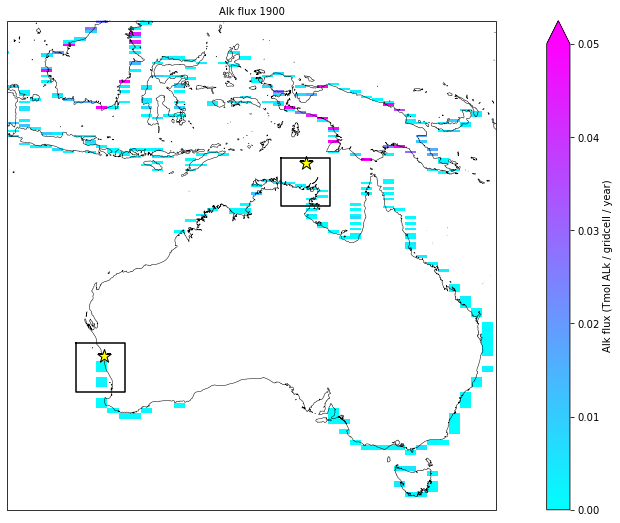

In [26]:
fig = plt.figure(figsize=(18,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([105, 155, -45, 5], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
alk_flux = ds_globalnews.alk_riv_flux.isel(time=0).where(ds_grid.REGION_MASK>0)
alk_flux = alk_flux.where(alk_flux > 0) * area * 86400. * 365 * 1e-9 * 1.e-12 # unit = mol Alk per year per gridcell
ax.set_title('Alk flux 1900', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_flux)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box14_lonmin,box14_lonmax,box14_lonmax,box14_lonmin,box14_lonmin]
lat_pts = [box14_latmax,box14_latmax,box14_latmin,box14_latmin,box14_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box15_lonmin,box15_lonmax,box15_lonmax,box15_lonmin,box15_lonmin]
lat_pts = [box15_latmax,box15_latmax,box15_latmin,box15_latmin,box15_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

for site in np.arange(0,15,1):
    lat = df_sites.loc[site]['Latitude (N)']
    lon = df_sites.loc[site]['Longitude (E)']
    sc = ax.scatter(lon, lat,color='yellow',marker='*',s=200,
                    edgecolor='black',zorder=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (Tmol ALk / gridcell / year)')


### Create a dataset that has each region mask as a variable name

In [27]:
ds_region_masks = xr.Dataset()

ds_region_masks['Reg_1'] = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
ds_region_masks['Reg_2'] = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)
ds_region_masks['Reg_3'] = ones.where(lats<box3_latmax).where(lats>box3_latmin).where(lons_norm<box3_lonmax).where(lons_norm>box3_lonmin)
ds_region_masks['Reg_4'] = ones.where(lats<box4_latmax).where(lats>box4_latmin).where(lons_norm<box4_lonmax).where(lons_norm>box4_lonmin)
ds_region_masks['Reg_5'] = ones.where(lats<box5_latmax).where(lats>box5_latmin).where(lons_norm<box5_lonmax).where(lons_norm>box5_lonmin)
ds_region_masks['Reg_6'] = ones.where(lats<box6_latmax).where(lats>box6_latmin).where(lons_norm<box6_lonmax).where(lons_norm>box6_lonmin)
ds_region_masks['Reg_7'] = ones.where(lats<box7_latmax).where(lats>box7_latmin).where(lons_norm<box7_lonmax).where(lons_norm>box7_lonmin)
ds_region_masks['Reg_8'] = ones.where(lats<box8_latmax).where(lats>box8_latmin).where(lons_norm<box8_lonmax).where(lons_norm>box8_lonmin)
ds_region_masks['Reg_9'] = ones.where(lats<box9_latmax).where(lats>box9_latmin).where(lons_norm<box9_lonmax).where(lons_norm>box9_lonmin)
ds_region_masks['Reg_10'] = ones.where(lats<box10_latmax).where(lats>box10_latmin).where(lons_norm<box10_lonmax).where(lons_norm>box10_lonmin)
ds_region_masks['Reg_11'] = ones.where(lats<box11_latmax).where(lats>box11_latmin).where(lons_norm<box11_lonmax).where(lons_norm>box11_lonmin)
ds_region_masks['Reg_12'] = ones.where(lats<box12_latmax).where(lats>box12_latmin).where(lons_norm<box12_lonmax).where(lons_norm>box12_lonmin)
ds_region_masks['Reg_13'] = ones.where(lats<box13_latmax).where(lats>box13_latmin).where(lons_norm<box13_lonmax).where(lons_norm>box13_lonmin)
ds_region_masks['Reg_14'] = ones.where(lats<box14_latmax).where(lats>box14_latmin).where(lons_norm<box14_lonmax).where(lons_norm>box14_lonmin)
ds_region_masks['Reg_15'] = ones.where(lats<box15_latmax).where(lats>box15_latmin).where(lons_norm<box15_lonmax).where(lons_norm>box15_lonmin)

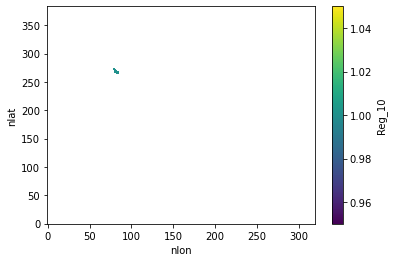

In [28]:
ds_region_masks['Reg_10'].plot()

### Cycle through regions and distribute 1/15 of total 5 Tmol Alk into each of 10 regions

In [33]:
tot_regs = 15
alk_per_reg_Tmol = 5/tot_regs
alk_per_reg_Tmol

0.3333333333333333

In [34]:
# count gridcells
num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks['Reg_2'].values))

# divide extra alk equally among the region's gridcells
alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

# masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
tmp = ds_region_masks['Reg_2'] * alk_to_add_per_gc 

### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks['Reg_2']==1) * 86400 * 365)


In [35]:
# count gridcells
num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks['Reg_1'].values))

# divide extra alk equally among the region's gridcells
alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

# masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
tmp = ds_region_masks['Reg_1'] * alk_to_add_per_gc 

### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks['Reg_1']==1) * 86400 * 365)


In [36]:
regions = ['Reg_1','Reg_2','Reg_3','Reg_4','Reg_5',
           'Reg_6','Reg_7','Reg_8','Reg_9','Reg_10',
           'Reg_11','Reg_12','Reg_13','Reg_14','Reg_15']

In [37]:
zeros = np.full((384,320),0,dtype=int)
zeros = xr.DataArray(zeros, dims=('nlat','nlon'))

i = 0

for reg in regions:
    
    ## count gridcells
    num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0).values))

    print(reg, ': ',num_gc_reg)
    
    ## divide extra alk equally among the region's gridcells
    alk_to_add_per_gc = alk_per_reg_Tmol/num_gc_reg

    # masks are ones just where the region is.. so this puts the amount of alk per gridcell on the global grid
    tmp = ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * alk_to_add_per_gc
    
    ### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
    tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks[reg]==1).where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * 86400. * 365.)

    if i == 0:

        add_alk_fluxes = zeros + tmp2.fillna(0)

    else:
        add_alk_fluxes = add_alk_fluxes.fillna(0) + tmp2.fillna(0)
        
    i = i + 1

add_alk_fluxes = add_alk_fluxes.where(ds_grid.REGION_MASK > 0)

Reg_1 :  3
Reg_2 :  3
Reg_3 :  3
Reg_4 :  4
Reg_5 :  6
Reg_6 :  6
Reg_7 :  2
Reg_8 :  3
Reg_9 :  4
Reg_10 :  5
Reg_11 :  3
Reg_12 :  5
Reg_13 :  6
Reg_14 :  4
Reg_15 :  7


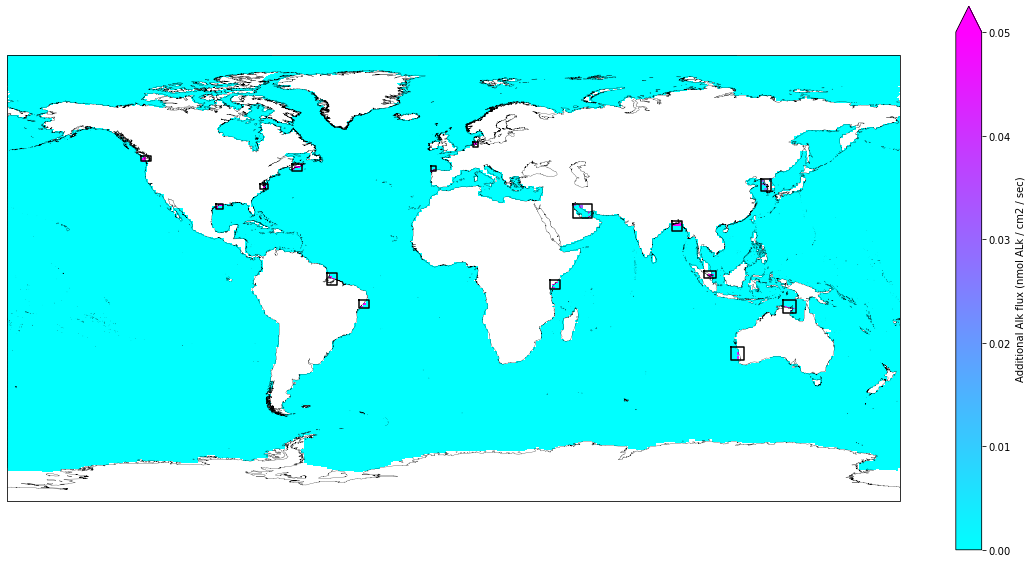

In [38]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.25)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  add_alk_fluxes)
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='cool',
                 transform=ccrs.PlateCarree())

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box5_lonmin,box5_lonmax,box5_lonmax,box5_lonmin,box5_lonmin]
lat_pts = [box5_latmax,box5_latmax,box5_latmin,box5_latmin,box5_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box6_lonmin,box6_lonmax,box6_lonmax,box6_lonmin,box6_lonmin]
lat_pts = [box6_latmax,box6_latmax,box6_latmin,box6_latmin,box6_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box7_lonmin,box7_lonmax,box7_lonmax,box7_lonmin,box7_lonmin]
lat_pts = [box7_latmax,box7_latmax,box7_latmin,box7_latmin,box7_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box8_lonmin,box8_lonmax,box8_lonmax,box8_lonmin,box8_lonmin]
lat_pts = [box8_latmax,box8_latmax,box8_latmin,box8_latmin,box8_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box9_lonmin,box9_lonmax,box9_lonmax,box9_lonmin,box9_lonmin]
lat_pts = [box9_latmax,box9_latmax,box9_latmin,box9_latmin,box9_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box10_lonmin,box10_lonmax,box10_lonmax,box10_lonmin,box10_lonmin]
lat_pts = [box10_latmax,box10_latmax,box10_latmin,box10_latmin,box10_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box11_lonmin,box11_lonmax,box11_lonmax,box11_lonmin,box11_lonmin]
lat_pts = [box11_latmax,box11_latmax,box11_latmin,box11_latmin,box11_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box12_lonmin,box12_lonmax,box12_lonmax,box12_lonmin,box12_lonmin]
lat_pts = [box12_latmax,box12_latmax,box12_latmin,box12_latmin,box12_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box13_lonmin,box13_lonmax,box13_lonmax,box13_lonmin,box13_lonmin]
lat_pts = [box13_latmax,box13_latmax,box13_latmin,box13_latmin,box13_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box14_lonmin,box14_lonmax,box14_lonmax,box14_lonmin,box14_lonmin]
lat_pts = [box14_latmax,box14_latmax,box14_latmin,box14_latmin,box14_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box15_lonmin,box15_lonmax,box15_lonmax,box15_lonmin,box15_lonmin]
lat_pts = [box15_latmax,box15_latmax,box15_latmin,box15_latmin,box15_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Additional Alk flux (nmol ALk / cm2 / sec)')

fig.savefig('/glade/work/kristenk/figs/extra_alk_fluxes.png', bbox_inches='tight', dpi=300, format='png');

### Total it back up and make sure I get 5 Tmol of alk per year

In [39]:
tmp = add_alk_fluxes * area #nmol/s/gridcell
tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
tmp3 = tmp2.sum(dim=('nlon','nlat'))
tmp3.values

array(5.)

### Figure out how to modify CFTime dimension

In [40]:
ds_globalnews.time

<xarray.DataArray 'time' (time: 21)>
array([cftime.DatetimeNoLeap(1900, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1905, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1910, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1915, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1925, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1930, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1935, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1940, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1945, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1950, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1955, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1960, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1970, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1975, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1985, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1990, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1995, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1900-07-01 12:00:00 ... 2000-07-01 12:00:00
Attributes:
    long_name:  time

In [41]:
test = [cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0),cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0)]
test = xr.DataArray(test,dims=('time'))
test

<xarray.DataArray (time: 2)>
array([cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0)], dtype=object)
Dimensions without coordinates: time

### create a 3D array of Alk additions with (time, lat, lon) spanning 1900 to 2100, every 5 years

In [44]:
xlen = len(ds_grid.nlon)
ylen = len(ds_grid.nlat)

In [45]:
## initialize the empty array
alk_adds = np.full((41,ylen,xlen),0,dtype=float)
alk_adds_tot = np.full((41,ylen,xlen),0,dtype=float)

glb_alk_adds = np.full((41),0,dtype=float)
glb_alk_adds_tot = np.full((41),0,dtype=float)

## cycling from 1900 to 2100, put alk addition every 5 years

t = 0 # time slice counter

for year in np.arange(1900,2105,5):

    print(year,t)

    ### create zero data array to start this year with, this could be replaced with actual global news alk array for this particular year
    zeros = np.full((384,320),0,dtype=int)
    zeros = xr.DataArray(zeros, dims=('nlat','nlon'))

    i = 0 #counter for regions
    
    ## how many Tmol alk to be distributed?
    if year <= 2020:
        tot_alk = 0
    elif year == 2025:
        tot_alk = 1
    elif year == 2030:
        tot_alk = 2
    elif year == 2035:
        tot_alk = 3
    elif year == 2040:
        tot_alk = 4
    elif year >= 2045:
        tot_alk = 5

    tot_alk_per_reg = tot_alk/tot_regs

    ## cycle through regions and distribute alkalinity
    for reg in regions:
        
        ## count gridcells
        num_gc_reg = np.count_nonzero(~np.isnan(ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0).values))
        
        ## figure out how much to add to each gridcell for this region 
        alk_to_add_per_gc = tot_alk_per_reg/num_gc_reg

        #print(reg, ': ',num_gc_reg,' gridcells so ', alk_to_add_per_gc, ' of alk per gridcell per year')
        
        tmp = ds_region_masks[reg].where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * alk_to_add_per_gc
        ### convert from Tmol Alk/gc/year to nmol Alk/cm2/sec
        
        tmp2 = (tmp * 1e12 * 1e9)/(area.where(ds_region_masks[reg]==1).where(ds_globalnews.alk_riv_flux.isel(time=0)>0) * 86400. * 365.)
    
        if i == 0:
    
            add_alk_fluxes = zeros + tmp2.fillna(0)
    
        else:
            add_alk_fluxes = add_alk_fluxes.fillna(0) + tmp2.fillna(0)
            
        #add_alk_fluxes = add_alk_fluxes.where(ds_grid.REGION_MASK > 0)
        i = i + 1

    alk_adds[t,:,:] = add_alk_fluxes

    if year <= 2000:
        alk_adds_tot[t,:,:] = ds_globalnews.alk_riv_flux.isel(time=t).values + add_alk_fluxes
    else:
        alk_adds_tot[t,:,:] = ds_globalnews.alk_riv_flux.isel(time=20).values + add_alk_fluxes
    

    #### total up to see how much alk adding this year

    tmp = alk_adds[t,:,:] * area #nmol/s/gridcell
    tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
    tmp3 = tmp2.sum(dim=('nlon','nlat'))
    print('adding ', tmp3.values, ' of Alk this year')
    glb_alk_adds[t] = tmp3.values

    tmp = alk_adds_tot[t,:,:] * area #nmol/s/gridcell
    tmp2 = tmp  * 1e-9 * 1e-12 * 86400 * 365
    tmp3 = tmp2.sum(dim=('nlon','nlat'))
    print('Total alk going into ocean: ', tmp3.values, ' this year')
    glb_alk_adds_tot[t] = tmp3.values
    
    t = t + 1

alk_adds = xr.DataArray(alk_adds,dims=('time','nlat','nlon'))
alk_adds_tot = xr.DataArray(alk_adds_tot,dims=('time','nlat','nlon'))
glb_alk_adds = xr.DataArray(glb_alk_adds,dims=('time'))
glb_alk_adds_tot = xr.DataArray(glb_alk_adds_tot,dims=('time'))

1900 0
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1905 1
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1910 2
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1915 3
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1920 4
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1925 5
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1930 6
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1935 7
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1940 8
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1945 9
adding  0.0  of Alk this year
Total alk going into ocean:  22.04719128377945  this year
1950 10
adding  0.0  of Alk this year
Total alk go

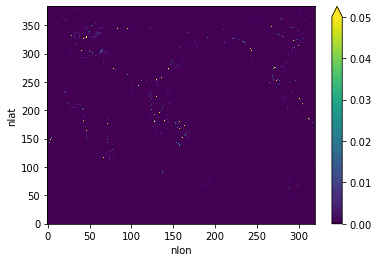

In [46]:
alk_adds_tot.isel(time=27).plot(vmin=0,vmax=0.05)

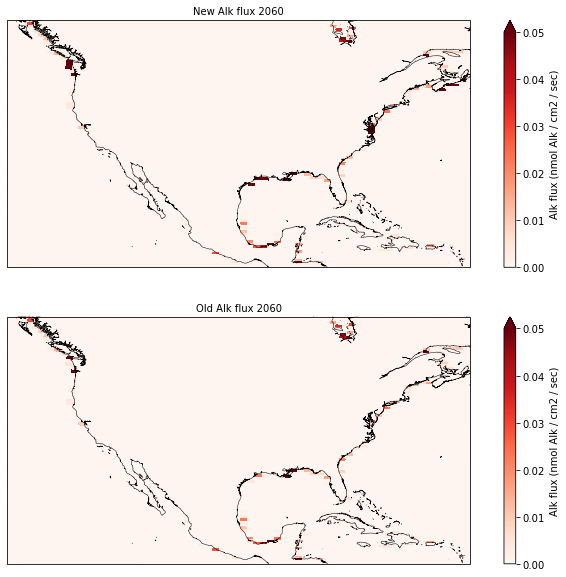

In [47]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-135, -60, 15, 55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('New Alk flux 2060', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  alk_adds_tot.isel(time=32))
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='Reds',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol Alk / cm2 / sec)')

ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-135, -60, 15, 55], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Old Alk flux 2060', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_globalnews.alk_riv_flux.isel(time=20))
pc1=ax.pcolormesh(lon, lat, 
                 field, 
                  vmin=0, vmax=0.05, 
                  cmap='Reds',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk flux (nmol Alk / cm2 / sec)')


### Prepare a netCDF to be written out, all other fields remain exactly the same through 2100

In [48]:
ds_globalnews.time[20]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2000, 7, 1, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2000-07-01 12:00:00
Attributes:
    long_name:  time

In [49]:
## what time-varying variables are in the netcdf?

variables2d = ['KMT','TAREA','pp_riv_flux_gnews','din_riv_flux_gnews','dop_riv_flux_gnews',
               'pn_riv_flux_gnews','dip_riv_flux_gnews','don_riv_flux_gnews']

variables3d = ['dsi_riv_flux','discharge_riv_flux_IMAGE_GNM','pn_riv_flux','Pload_riv_flux_IMAGE_GNM',
               'Nload_riv_flux_IMAGE_GNM','doc_riv_flux','dip_riv_flux','dop_riv_flux','dic_riv_flux',
               'din_riv_flux','don_riv_flux','pp_riv_flux','dfe_riv_flux','poc_riv_flux']

alk_var = 'alk_riv_flux'

In [50]:
len(variables2d) + len(variables3d) + 1 #(for alk var)

23

#### first add 2d vars

In [51]:
ds_out = xr.Dataset()

for var in variables2d:
    ds_out[var] = ds_globalnews[var]

In [52]:
ds_out.attrs = ds_globalnews.attrs

In [53]:
ds_out.attrs['modifications'] =  'adding extra alkalinity to natural alkalinity river fluxes for OAE experiments'
ds_out.attrs['notes2'] = 'modified by Kristen Krumhardt, August 13 2025'

### Now add the 3d fields

In [54]:
variables3d[0]

'dsi_riv_flux'

In [55]:
for var in variables3d: #this list does NOT have alk in it, will add afterwards
    print(var)
    var_array = np.full((41,ylen,xlen),0,dtype=float)
    
    t = 0 # time slice counter
    
    for year in np.arange(1900,2105,5):
    
        #print(year,t)
        
        if year <= 2000:
            var_array[t,:,:] = ds_globalnews[var].isel(time=t).values
        else:
            var_array[t,:,:] = ds_globalnews[var].isel(time=20).values
        
        t = t + 1

    ## now turn it into an xarray, add the same attributes as the original var and then add it ds_out
    var_array = xr.DataArray(var_array,dims=('time','nlat','nlon'))

    var_array.attrs = ds_globalnews[var].attrs

    ds_out[var] = var_array

####### Now add the new alkalinity!!!

ds_out[alk_var] = alk_adds_tot
ds_out[alk_var].attrs = ds_globalnews[alk_var].attrs
ds_out[alk_var].attrs['notes'] = 'added alk for OAE experiments'


dsi_riv_flux
discharge_riv_flux_IMAGE_GNM
pn_riv_flux
Pload_riv_flux_IMAGE_GNM
Nload_riv_flux_IMAGE_GNM
doc_riv_flux
dip_riv_flux
dop_riv_flux
dic_riv_flux
din_riv_flux
don_riv_flux
pp_riv_flux
dfe_riv_flux
poc_riv_flux


In [56]:
ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 384, nlon: 320, time: 41)
Coordinates:
    TLAT                          (nlat, nlon) float64 ...
    TLONG                         (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon, time
Data variables: (12/23)
    KMT                           (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
    pp_riv_flux_gnews             (nlat, nlon) float64 ...
    din_riv_flux_gnews            (nlat, nlon) float64 ...
    dop_riv_flux_gnews            (nlat, nlon) float64 ...
    pn_riv_flux_gnews             (nlat, nlon) float64 ...
    ...                            ...
    din_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    don_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    pp_riv_flux                   (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    dfe_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    poc_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    alk_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    note:           Created by M. Long (NCAR) 2017-04-25
    source:         Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https...
    assumptions:    Dissolved inorganic carbon (DIC) in freshwater inputs is ...
    mapping:        Nutrient file on runoff grid: /glade/p/work/mclong/cesm_i...
    procedure:      Data sets were interpolated to the runoff grid, then mapp...
    modifications:  adding extra alkalinity to natural alkalinity river fluxe...
    notes2:         modified by Kristen Krumhardt, August 13 2025

### Now make a CFTime time dimension

In [57]:
time_dim = np.empty((41), dtype=object)

t = 0 # time slice counter

for year in np.arange(1900,2105,5):

    time_dim[t] = cftime.DatetimeNoLeap(year, 7, 1, 12, 0, 0, 0)

    t = t + 1

time_dim = xr.DataArray(time_dim,dims=('time'))
time_dim

<xarray.DataArray (time: 41)>
array([cftime.DatetimeNoLeap(1900, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1905, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1910, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1915, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1925, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1930, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1935, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1940, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1945, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1950, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1955, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1960, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1970, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1975, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1985, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1990, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1995, 7, 1, 12, 0, 0, 0),
...
       cftime.DatetimeNoLeap(2005, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2020, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2025, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2030, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2035, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2040, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2045, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2050, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2055, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2060, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2065, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2070, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2075, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2080, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2085, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2090, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2095, 7, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 7, 1, 12, 0, 0, 0)], dtype=object)
Dimensions without coordinates: time

In [58]:
ds_out['time'] = time_dim

ds_out['time'].attrs = ds_globalnews.time.attrs

In [59]:
ds_out['time'].attrs

{'long_name': 'time'}

In [60]:
ds_out

<xarray.Dataset>
Dimensions:                       (nlat: 384, nlon: 320, time: 41)
Coordinates:
    TLAT                          (nlat, nlon) float64 ...
    TLONG                         (nlat, nlon) float64 ...
  * time                          (time) object 1900-07-01 12:00:00 ... 2100-...
Dimensions without coordinates: nlat, nlon
Data variables: (12/23)
    KMT                           (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
    pp_riv_flux_gnews             (nlat, nlon) float64 ...
    din_riv_flux_gnews            (nlat, nlon) float64 ...
    dop_riv_flux_gnews            (nlat, nlon) float64 ...
    pn_riv_flux_gnews             (nlat, nlon) float64 ...
    ...                            ...
    din_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    don_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    pp_riv_flux                   (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    dfe_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    poc_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
    alk_riv_flux                  (time, nlat, nlon) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    note:           Created by M. Long (NCAR) 2017-04-25
    source:         Blend of GlobalNEWS and IMAGE-GNM data: GlobalNEWS: https...
    assumptions:    Dissolved inorganic carbon (DIC) in freshwater inputs is ...
    mapping:        Nutrient file on runoff grid: /glade/p/work/mclong/cesm_i...
    procedure:      Data sets were interpolated to the runoff grid, then mapp...
    modifications:  adding extra alkalinity to natural alkalinity river fluxe...
    notes2:         modified by Kristen Krumhardt, August 13 2025

In [61]:
filename='riv_nut.gnews_gnm.gx1v7_nn_open_ocean_nnsm_e1000r300_marginal_sea.OAE_testexp.20250813.nc'

ds_out.to_netcdf('/glade/derecho/scratch/kristenk/OAE_experiment_data/'+filename, format="NETCDF4_CLASSIC",mode='w')

# format: The netCDF format to use (e.g., "NETCDF4", "NETCDF4_CLASSIC")